# This script is a test to import ND2 files and analyze them

In [26]:
!pip show nd2

Name: nd2
Version: 0.10.1
Summary: Yet another nd2 (Nikon NIS Elements) file reader
Home-page: https://github.com/tlambert03/nd2
Author: 
Author-email: Talley Lambert <talley.lambert@gmail.com>
License: BSD 3-Clause License
Location: c:\users\niklas\miniconda3\envs\pybias-env\lib\site-packages
Requires: numpy, ome-types, resource-backed-dask-array, typing-extensions
Required-by: 


In [124]:
import nd2
import numpy as np
import matplotlib.pyplot as plt
import stackview

## Open nd2 file

In [125]:
with nd2.ND2File('E:/20240627_SYN_MAP2/240627-H1-day53-BDNF.nd2') as figure:
    #Read the entire file into a numpy array
    image = figure.asarray() #This will read the image data

#Print the shape and data type of the image
print(f"File path: {figure.path}")
print(f"File shape: {figure.shape}")
print(f"Number of dimensions: {figure.ndim}")
print(f"Data type: {figure.dtype}")
print(f"Total voxel elements: {figure.size}")
print(f"Dimensions: {figure.sizes}")
print(f"Is RGB: {figure.is_rgb}")

# Access individual channels, assuming image shape is (frames, channels, height, width)
ch0 = image[:, 0, :, :].squeeze()  # Access the first frame and all channels
ch1 = image[:, 1, :, :].squeeze()  # Access the second frame
ch2 = image[:, 2, :, :].squeeze()  # Access the third frame

# Print shapes of individual channels
print(ch0.shape)  # Check shape of channel 0
print(ch1.shape)  # Check shape of channel 1
print(ch2.shape)  # Check shape of channel 2

# Example to visualize one of the channels
#plt.figure(figsize=(10, 8))
#plt.imshow(ch0, cmap='gray')  # Display the first channel
#plt.title('Channel 0')
#plt.colorbar()
#plt.show()

    

File path: E:\20240627_SYN_MAP2\240627-H1-day53-BDNF.nd2
File shape: (13, 3, 2048, 2048)
Number of dimensions: 4
Data type: uint16
Total voxel elements: 163577856
Dimensions: {'Z': 13, 'C': 3, 'Y': 2048, 'X': 2048}
Is RGB: False
(13, 2048, 2048)
(13, 2048, 2048)
(13, 2048, 2048)


# View the volume slice-by-slice:

In [123]:
stackview.slice(ch0, continuous_update=True)

### Plot figure

# Get also the orthogonal views

In [126]:
stackview.orthogonal(ch0, continuous_update=True)

# Get some basic info about the image

StackViewNDArray([[39, 39, 49, ..., 39, 33, 44],
                  [37, 39, 37, ..., 39, 41, 37],
                  [42, 36, 33, ..., 37, 39, 39],
                  ...,
                  [38, 36, 36, ..., 37, 35, 35],
                  [37, 38, 38, ..., 40, 41, 45],
                  [36, 42, 34, ..., 42, 36, 45]], dtype=uint16)
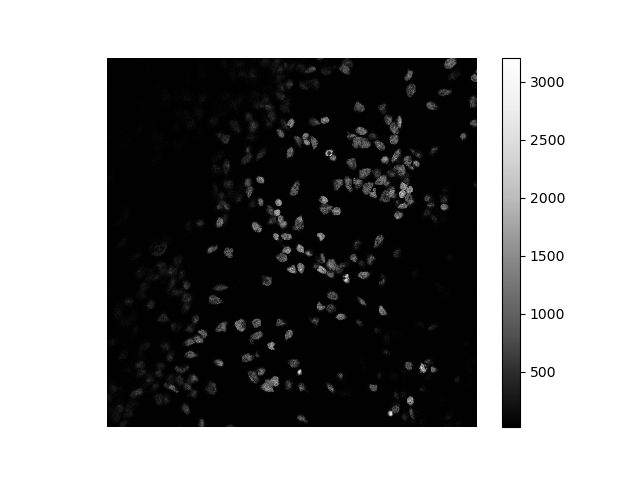
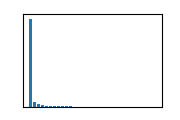

In [127]:
stackview.insight(ch0[5,:,:])

# Compare two channels

In [97]:
stackview.side_by_side(ch0* (255/ch0.max()),
                       ch2* (255/ch2.max()), 
                       display_max=255,
                       continuous_update=True, 
                       display_width=300)

side_by_side


### You can also view multiple channels with different colormaps at the same time

StackViewNDArray([[22, 12, 15, ..., 74, 57, 48],
                  [14, 17, 21, ..., 64, 43, 50],
                  [18, 17, 12, ..., 61, 51, 47],
                  ...,
                  [19, 22, 13, ..., 11, 10, 12],
                  [19, 17, 21, ..., 14, 14, 11],
                  [18, 18, 24, ..., 12, 12, 14]], dtype=uint16)
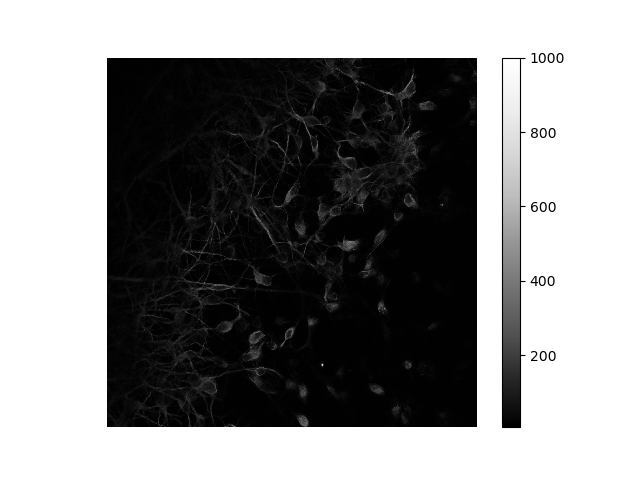
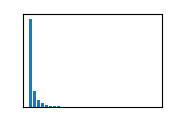

In [100]:
# normalization
z_idx = 4
nuc = ch0[z_idx,:,:].squeeze()
nuc = nuc * (1000/nuc.max())
nuc = nuc.astype(np.uint16)

cyto = ch1[z_idx,:,:].squeeze()
cyto = cyto * (1000/cyto.max())
cyto = cyto.astype(np.uint16)

pbod = ch2[z_idx,:,:].squeeze()
pbod = pbod * (1000/pbod.max())
pbod = pbod.astype(np.uint16)
stackview.insight(pbod)

In [101]:
# toggleable display 
# change titles to get what you have 
stackview.switch(
    {"nucleus":   nuc,
     "cytoplasm": cyto,
     "p bodies":  pbod
    },
    colormap=["pure_blue", "pure_green", "gray"],
    toggleable=True,
    display_max=1000
)

min pixel value:  22
max pixel value:  3830


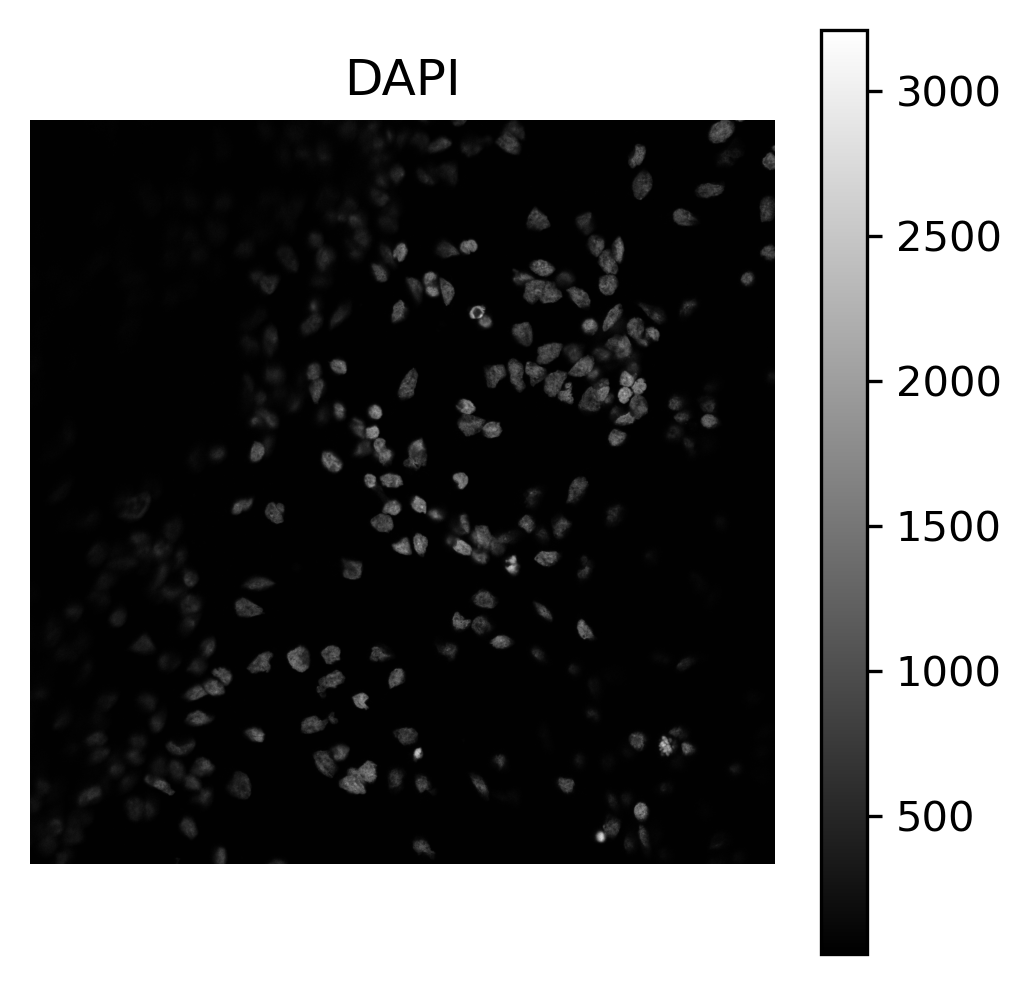

In [106]:
plt.figure(figsize=(4, 4), dpi=300)
plt.imshow(ch0[5], cmap="gray")
plt.colorbar()
plt.title('DAPI')
plt.axis('off')
# also print the min and max value of the iamge
print('min pixel value: ', ch0.min())
print('max pixel value: ', ch0.max())

# Trying to segment the image
## Let us try to segment the image without any pre-processing using the otsu method

In [107]:
# importing otsu from scikit-image
from skimage.filters import threshold_otsu

## Segment the image and show the results

The value is:  449


(np.float64(-0.5), np.float64(2047.5), np.float64(2047.5), np.float64(-0.5))

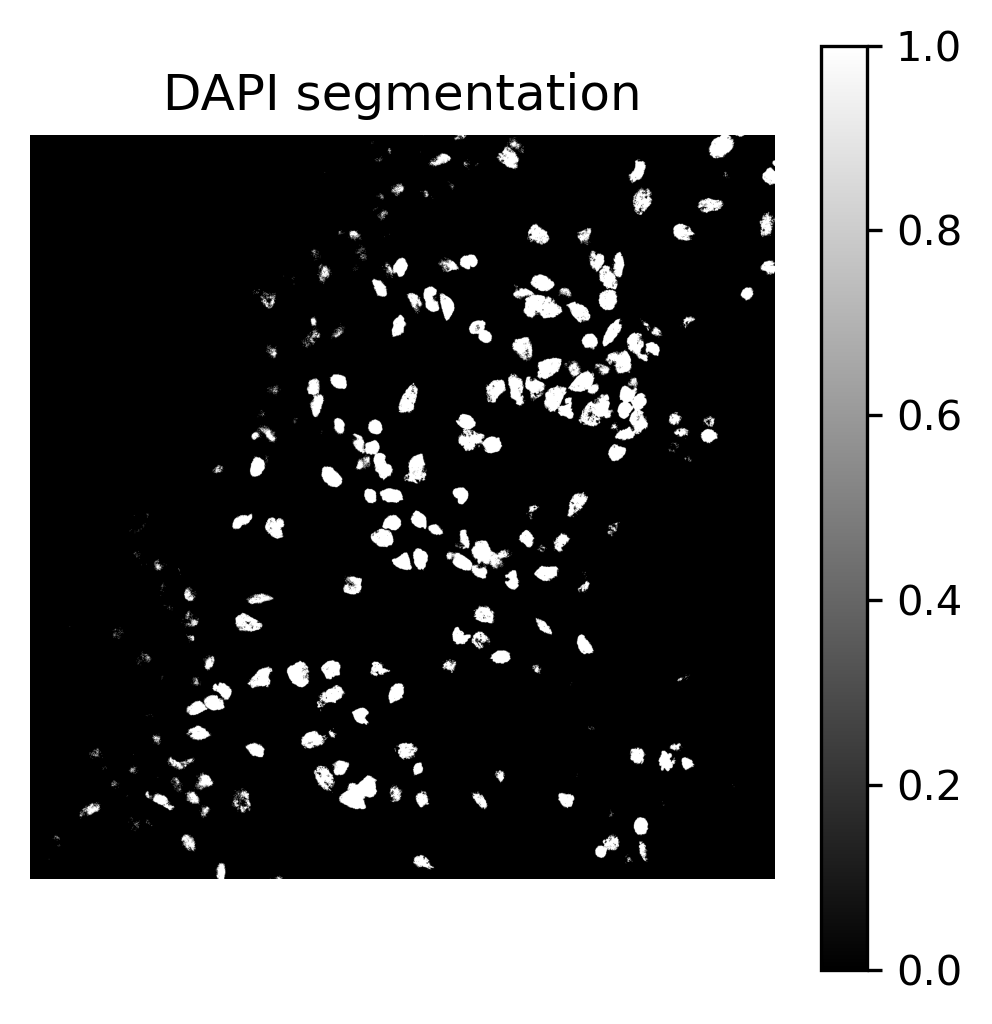

In [111]:
th_val = threshold_otsu(ch0[5])
print('The value is: ', th_val)
bw_otsu = ch0[5] > th_val
plt.figure(figsize=(4, 4), dpi=300)
plt.imshow(bw_otsu, cmap='gray')
plt.colorbar()
plt.title('DAPI segmentation')
plt.axis('off')

## Pre-processing to remove uneven illumination
### For this we will use a simple gaussian blurr

In [112]:
# importing gaussian filter from scikit-image
from skimage.filters import gaussian

(np.float64(-0.5), np.float64(2047.5), np.float64(2047.5), np.float64(-0.5))

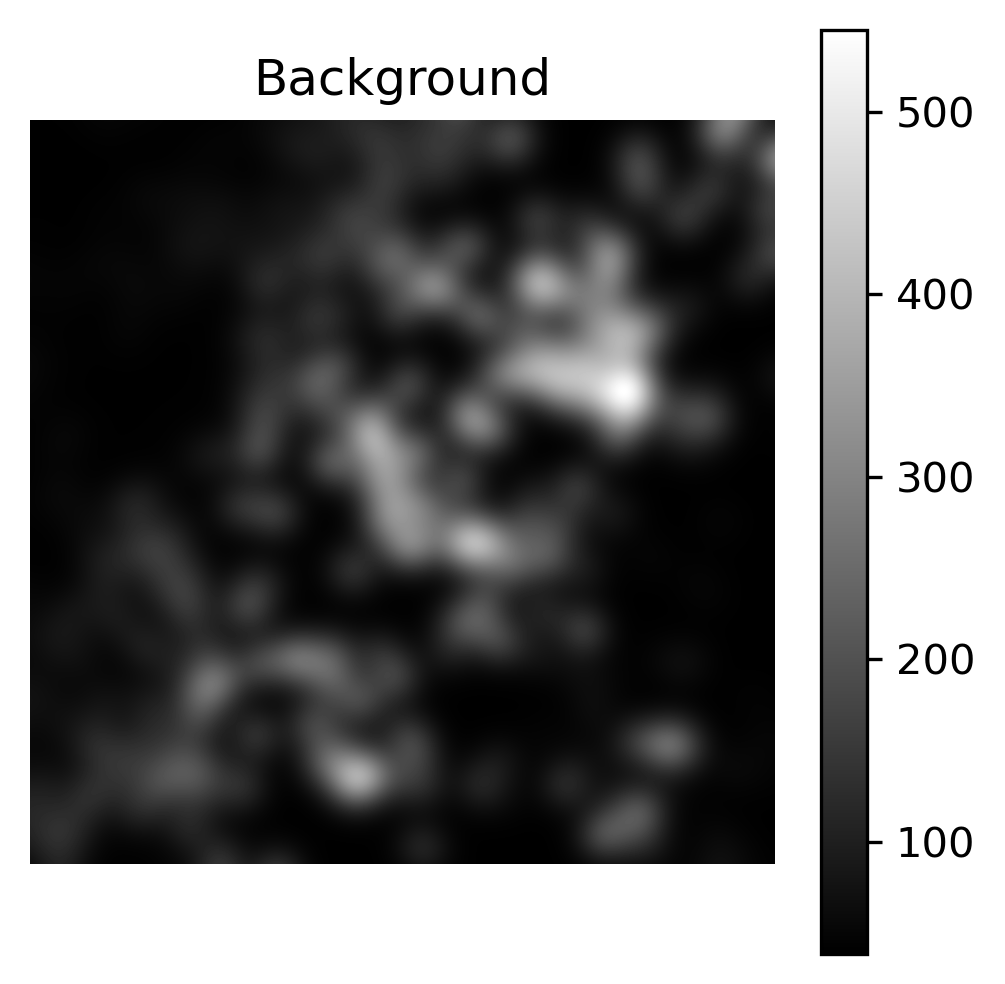

In [114]:
img_bg = gaussian(ch0[5],sigma=50,preserve_range=True)
plt.figure(figsize=(4, 4), dpi=300)
plt.imshow(img_bg, cmap=plt.cm.gray)
plt.colorbar()
plt.title('Background')
plt.axis('off')

### Remove background from image

min pixel value:  -500.67561983041276
max pixel value:  3026.613400705576


(np.float64(-0.5), np.float64(2047.5), np.float64(2047.5), np.float64(-0.5))

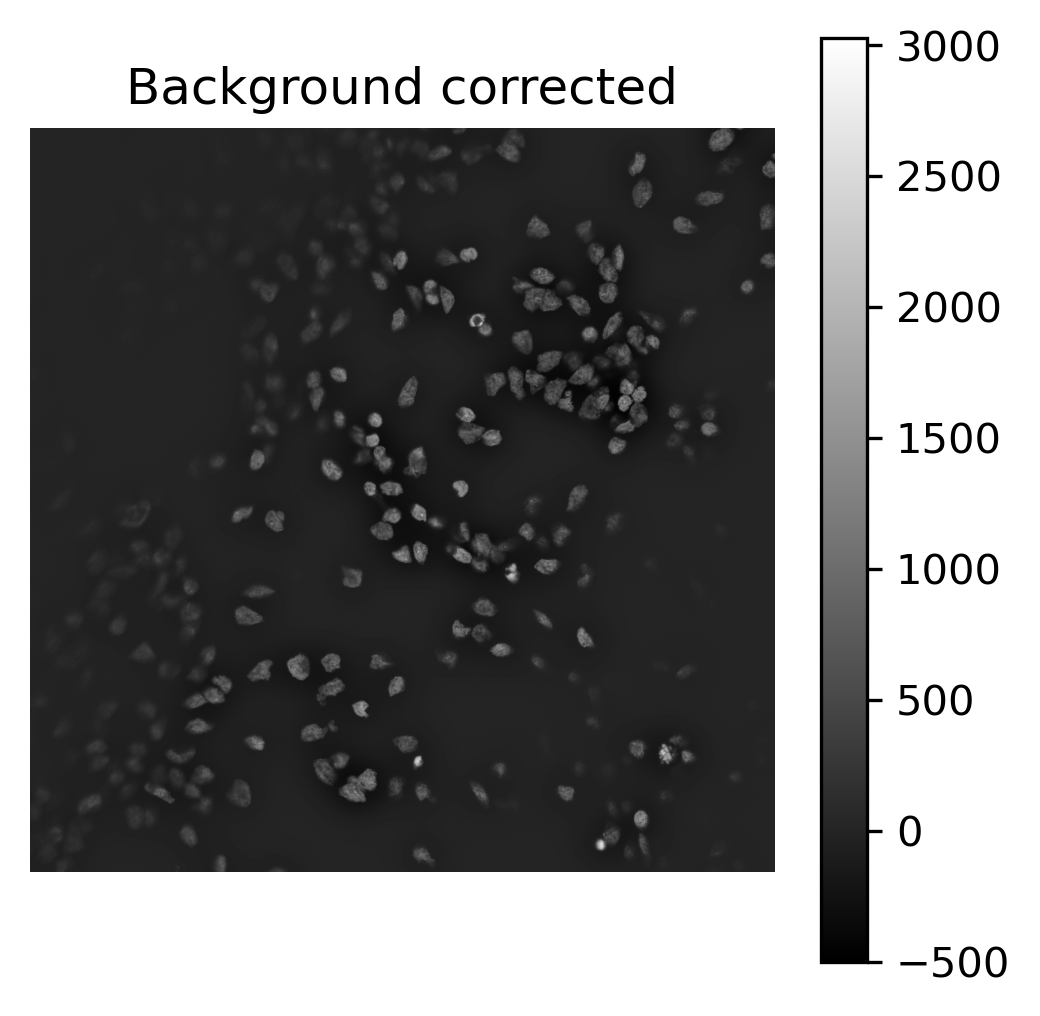

In [115]:
img_no_bg = ch0[5] - img_bg
plt.figure(figsize=(4, 4), dpi=300)
plt.imshow(img_no_bg, cmap='gray')
plt.colorbar()
print('min pixel value: ',img_no_bg.min())
print('max pixel value: ',img_no_bg.max())
plt.title('Background corrected')
plt.axis('off')

### Now we segment the pre-processed image

The value is:  291.5865625165379


(np.float64(-0.5), np.float64(2047.5), np.float64(2047.5), np.float64(-0.5))

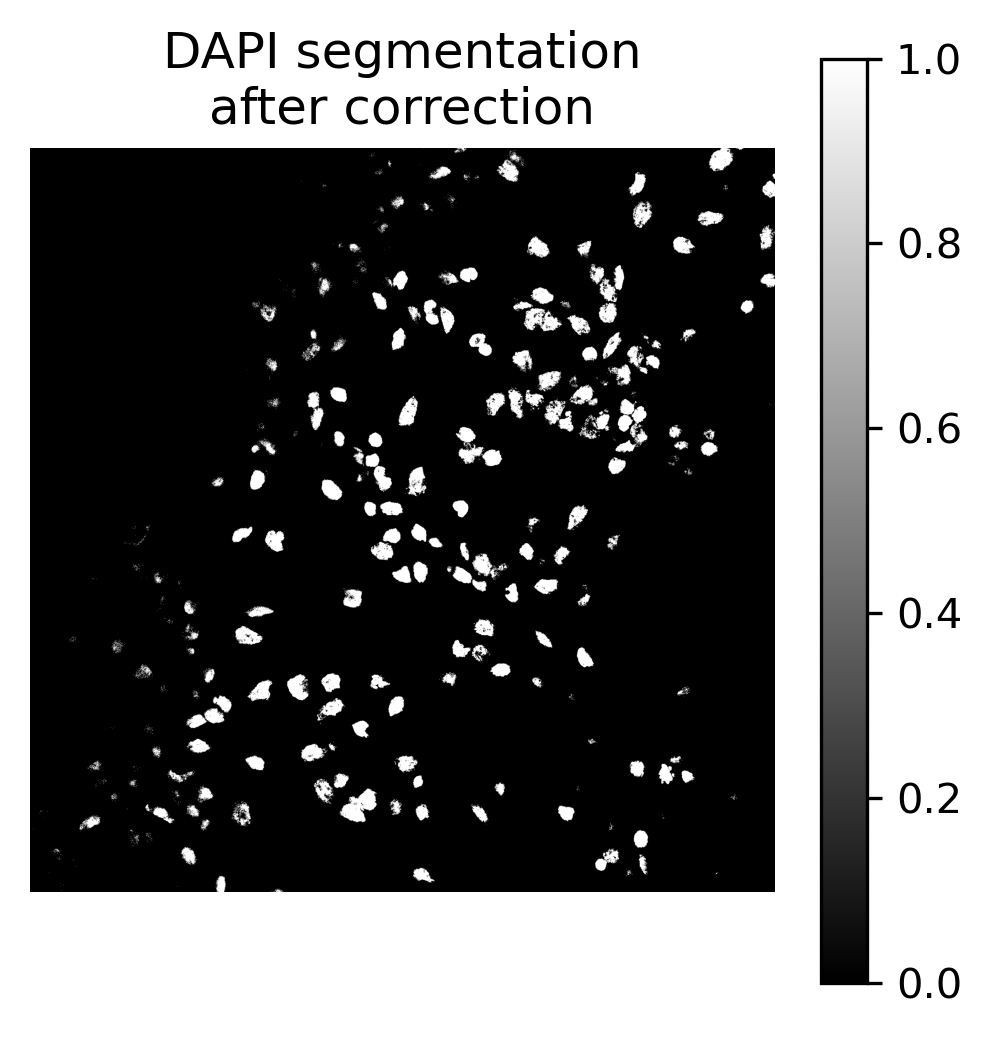

In [117]:
th_val = threshold_otsu(img_no_bg)
print('The value is: ', th_val)
bw_otsu = img_no_bg > th_val
plt.figure(figsize=(4, 4), dpi=300)
plt.imshow(bw_otsu, cmap='gray')
plt.colorbar()
plt.title('DAPI segmentation\nafter correction')
plt.axis('off')

## Simple quantification
### Now we will use scikit-image together with pandas to create output tables from our results and then plot some values of interest, in this case area.

In [118]:
import pandas as pd
from skimage.measure import label, regionprops_table
from skimage.segmentation import clear_border
from skimage.morphology import area_opening

(np.float64(-0.5), np.float64(2047.5), np.float64(2047.5), np.float64(-0.5))

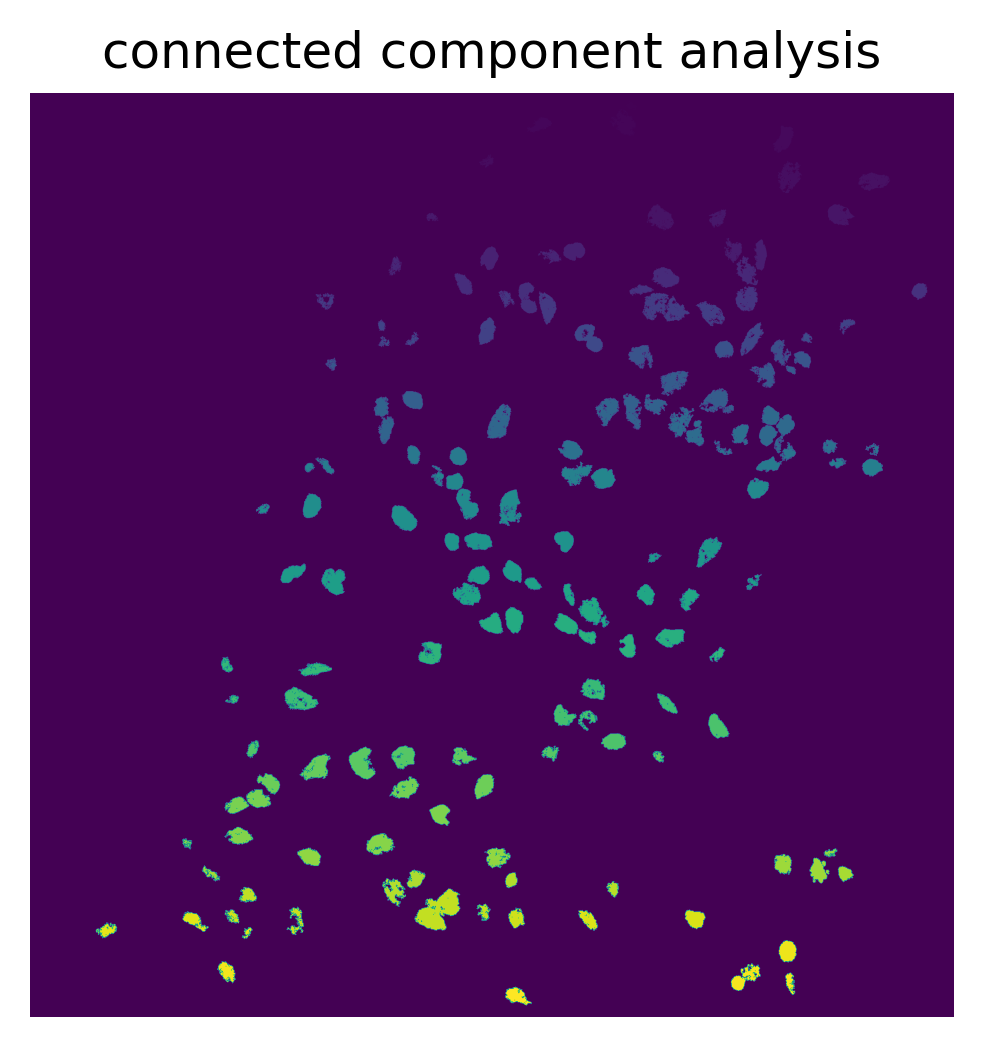

In [119]:
# remove segmentations that touch the border of the iamge
mask = clear_border(bw_otsu)
# remove small objects
mask = area_opening(mask, area_threshold=200)
# run connected component analysis
lbl = label(mask)
# plot the retuls
plt.figure(figsize=(4, 4), dpi=300)
plt.imshow(lbl)
plt.title('connected component analysis')
plt.axis('off')

### Now we can calculate some properties, both morphological and intensity based

   label    area  eccentricity  intensity_mean
0      1   250.0      0.782680      557.816000
1      2  1906.0      0.680155      678.594439
2      3   956.0      0.885815      602.211297
3      4  1599.0      0.858730      863.852408
4      5   419.0      0.760087      535.675418
            label         area  eccentricity  intensity_mean
count  155.000000   155.000000    155.000000      155.000000
mean    78.000000  1287.890323      0.724891      827.179518
std     44.888751   736.656879      0.139355      229.634508
min      1.000000   250.000000      0.356999      477.653740
25%     39.500000   687.500000      0.629951      644.746305
50%     78.000000  1292.000000      0.760087      795.234494
75%    116.500000  1741.500000      0.832042      971.210076
max    155.000000  5075.000000      0.952431     1462.238095


array([[<Axes: title={'center': 'area'}>]], dtype=object)

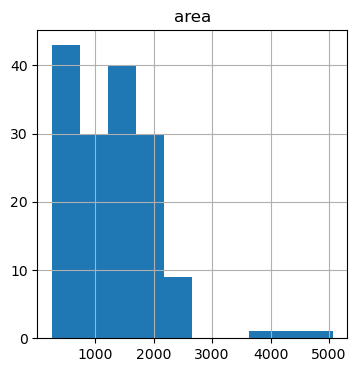

In [122]:
properties = ['label', 'area','eccentricity','intensity_mean']
table = regionprops_table(label_image=lbl,
                          intensity_image=ch0[5],
                          properties=properties)
table = pd.DataFrame(table)
print(table.head())
print(table.describe())
table.hist(column='area', figsize=(4, 4))